# Probit Model - ∂versions

only old behav_fit environments seem to work with model-fitting (behav_fit_2_clone)

* fit ∂versions (1,2-[∂format],3,4(x:c(n_safe)))

* Analyse posteriors
    * fast plotting
    * stake size specific gammas
    * easier readable gamma, intercept & RNP - per group & format + group-diff

* PPCs --> automatically save to plot_folder (bids_folder, 'plots_and_ims', 'behavior_risk')

In [1]:
# behav_fit2_clone ?! behav_fit not

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import bambi
import arviz as az

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')
plot_folder = op.join(bids_folder, 'plots_and_ims', 'behavior_risk')

from utils import get_data
import numpy as np
           
df = get_data()
df['x'] = df['log(risky/safe)'] 

group_list = df.reset_index().drop_duplicates(subset=['subject', 'group'])[['subject', 'group']]

number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [3]:
model_label = 1
format = 'both'

model = bambi.Model('chose_risky ~ x + x*group*format + (x*format|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [25]:
model_label = '1rem1'
format = 'both'

subList_remove = [32,40,45,46,50]
df_fil = df.loc[~df.index.get_level_values('subject').isin(subList_remove)] # only 10 subs to check model fitting

model = bambi.Model('chose_risky ~ x + x*group*format + (x*format|subject)', link='probit', family='bernoulli', data=df_fil.reset_index())

In [2]:
model_label = 2

format = 'symbolic'
data = df.xs(format, 0, level='format')
model = bambi.Model('chose_risky ~ x + x*group*n_safe + (x*n_safe|subject)', link='probit', family='bernoulli', data=data.reset_index())

In [20]:
model_label = 3
format = 'both'

model = bambi.Model('chose_risky ~ x + x*group*format*n_safe + (x*format*n_safe|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [3]:
model_label = 4
format = 'symbolic'
data = df.xs(format, 0, level='format')
model = bambi.Model('chose_risky ~ x + x*group*C(n_safe) + (x*C(n_safe)|subject)', link='probit', family='bernoulli', data=data.reset_index())

In [66]:
model_label = '4rem1'
format = 'symbolic'
subList_remove = [32,40,45,46,50]
df_fil = df.loc[~df.index.get_level_values('subject').isin(subList_remove)] # only 10 subs to check model fitting

data = df_fil.xs(format, 0, level='format')
model = bambi.Model('chose_risky ~ x + x*group*C(n_safe) + (x*C(n_safe)|subject)', link='probit', family='bernoulli', data=data.reset_index())

### fit probit via bambi

In [67]:
traces = model.fit(init='adapt_diag', target_accept=0.9, draws=1000, tune=1000)

az.to_netcdf(traces, op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))

Modeling the probability that chose_risky==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, group, x:group, C(n_safe), x:C(n_safe), group:C(n_safe), x:group:C(n_safe), 1|subject_sigma, 1|subject_offset, x|subject_sigma, x|subject_offset, C(n_safe)|subject_sigma, C(n_safe)|subject_offset, x:C(n_safe)|subject_sigma, x:C(n_safe)|subject_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 678 seconds.


'/Users/mrenke/data/ds-dnumrisk/derivatives/cogmodels_risk/rnp_model-4rem1_format-symbolic_trace.netcdf'

### load in traces

In [3]:
model_label = 2 # 1 '1rem1' #3 
format = 'non-symbolic' # 'both' # 'non-symbolic' # 

traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))


## Analyse traces/posteriors

#### fast plotting of regressors

2 non-symbolic
Intercept: mean=-2.3553873681179924, 95%CI=[-2.81186039 -1.90963236]
x: mean=2.3784759841274417, 95%CI=[2.00335464 2.76095825]
group: mean=0.6104624706609825, 95%CI=[-0.01273666  1.2365291 ]
x:group: mean=-0.7597921582847642, 95%CI=[-1.27630842 -0.25149892]
n_safe: mean=0.0015102380024997549, 95%CI=[-0.01637323  0.01963159]
x:n_safe: mean=0.008678793847748799, 95%CI=[-0.01112968  0.02987392]
group:n_safe: mean=-0.012935042083214922, 95%CI=[-0.0379278   0.01219618]
x:group:n_safe: mean=0.019434244466668298, 95%CI=[-0.00927863  0.04816143]


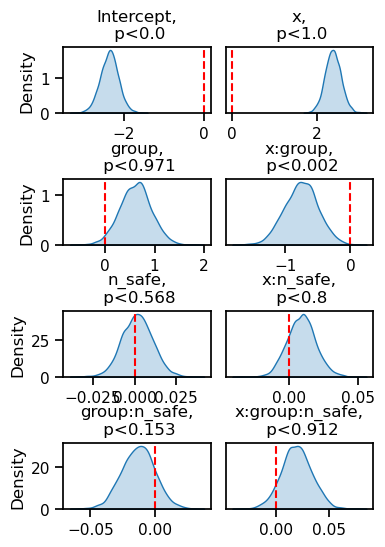

In [36]:
print(model_label, format)
sns.set_context('notebook')

variable_names = list(traces.posterior.data_vars.keys())  # variable_names = list(traces.posterior.data_vars.keys()) 
variable_names = [x for x in variable_names if 'subject' not in x] # remove sd

n_rows = int(len(variable_names) / 2 )
fig, axs = plt.subplots(n_rows,2, figsize=(4,6), sharex=False)

for i in range(n_rows):
    for j in range(2): # intercept & slope 
        index = i * 2 + j
        var = variable_names[index] # goes till 7/8
        temp = traces.posterior[var].to_dataframe()
        count_greater_zero = np.round(np.mean(temp[var] > 0),3)
        sns.kdeplot(temp, ax=axs[i, j],legend=False, fill=True)
        if j!= 0:
            axs[i, j].set(yticks=[],ylabel='')
        axs[i, j].axvline(x=0, color='r', linestyle='--')
        axs[i, j].set_title(f'{var},\n p<{count_greater_zero}')
        print(f'{var}: mean={temp[var].mean()}, 95%CI={np.percentile(temp[var], [2.5, 97.5])}')

fig.subplots_adjust(wspace=0.1, hspace=1)
#plt.savefig(op.join(plot_folder, f'rnp_model-{model_label}_format-{format}_regressors.pdf'))

### stake-size specific slope

In [14]:
from utils import invprobit

data = df.xs(format, 0, level='format')
fake_data = pd.MultiIndex.from_product([[0,1],[0, 1], data['n_safe'].unique()], #x, group stake
                                    names=['x','group', 'n_safe']).to_frame(index=False)

pred = model.predict(traces, 'mean', fake_data, inplace=False, include_group_specific=False)['posterior']['chose_risky_mean'] # when no subjects! include_group_specific=False
pred = pred.to_dataframe().unstack([0, 1])
pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))

# return pred
pred0 = pred.xs(0, 0, 'x')
intercept = pd.DataFrame(invprobit(pred0), index=pred0.index, columns=pred0.columns)
gamma = invprobit(pred.xs(1, 0, 'x')) - intercept
rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])
rnp.columns = ['rnp']

gamma = gamma.stack([1,2])
gamma.columns = ['gamma']

intercept = intercept.stack([1,2])
intercept.columns = ['intercept']



Text(0.5, 1.0, 'model-2, format: non-symbolic')

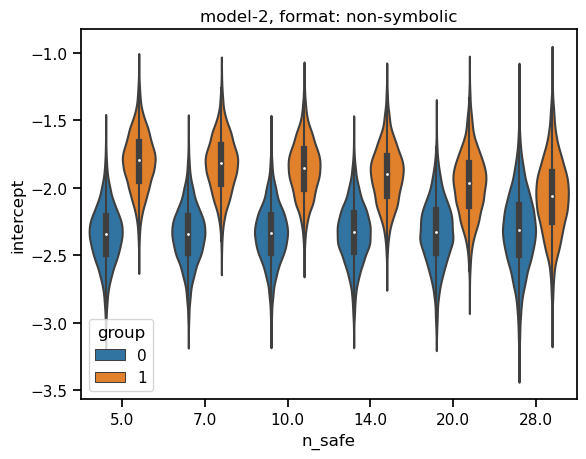

In [38]:
sns.violinplot(data=intercept.reset_index(), x='n_safe',y='intercept',hue='group')
plt.title(f'model-{model_label}, format: {format}')

Text(0.5, 1.0, 'model-2, format: non-symbolic')

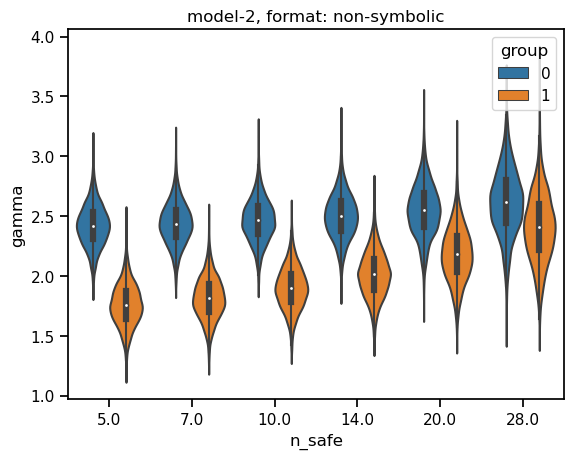

In [39]:
sns.violinplot(data=gamma.reset_index(), x='n_safe',y='gamma',hue='group')
plt.title(f'model-{model_label}, format: {format}')

Text(0.5, 1.0, 'model-2, format: non-symbolic')

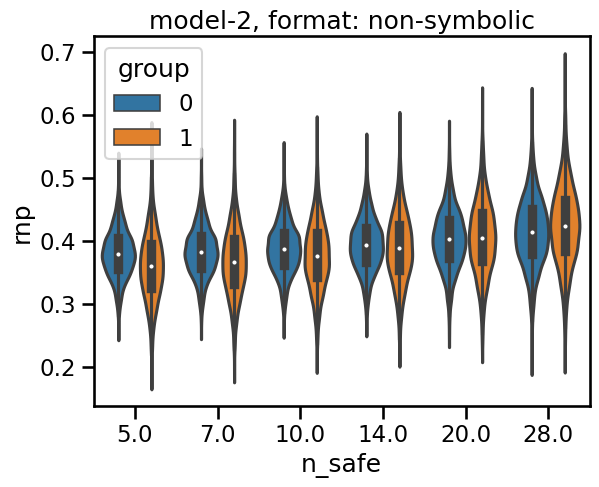

In [15]:
sns.violinplot(data=rnp.reset_index(), x='n_safe',y='rnp',hue='group')
plt.title(f'model-{model_label}, format: {format}')

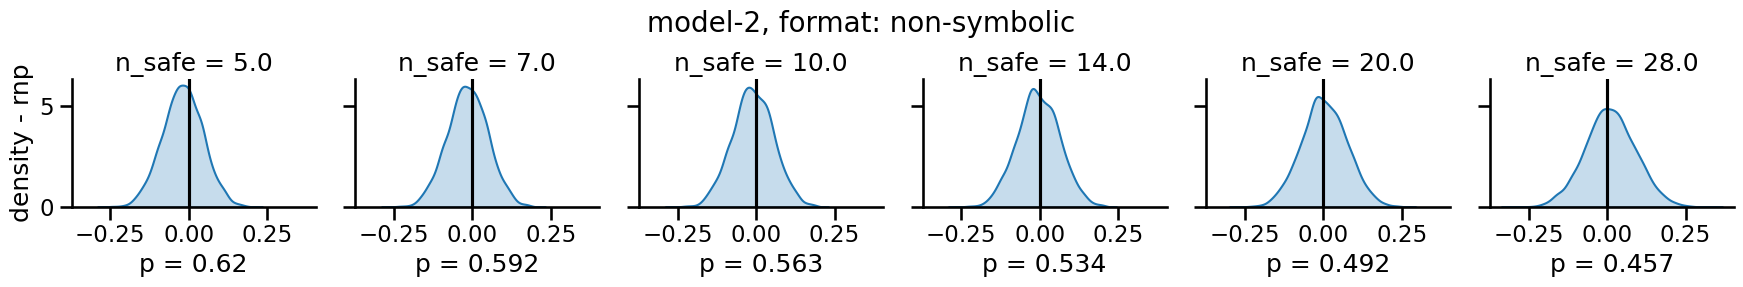

In [12]:
sns.set_context('talk')

param = 'rnp'
temp = rnp.unstack('group').droplevel(0, axis=1)
diff = (temp[1] - temp[0]).to_frame('diff')
g = sns.FacetGrid(diff.reset_index(),col='n_safe' )
g.map(sns.kdeplot, 'diff', fill=True)
g.map(plt.axvline, x=0.0,c='k')

for i,n1 in enumerate(diff.index.unique('n_safe').values):
    d = diff.xs(n1, 0,'n_safe')
    p_val = np.round(((d<0.0).mean())[0], 3)
    g.axes[0][i].set_xlabel(f'p = {p_val}')
g.axes[0][0].set_ylabel(f'density - {param}')
g.fig.suptitle(f'model-{model_label}, format: {format}',fontsize=20)
g.fig.subplots_adjust(top=0.75)

#### more readable posterior evidence

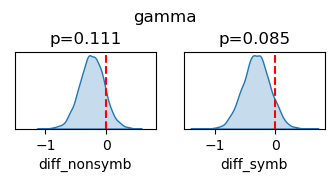

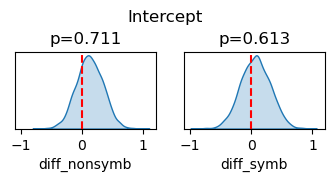

In [115]:
for param in ['gamma', 'Intercept']:
    var = 'x:' if param == 'gamma' else ''
    df_g = traces.posterior[f'{var}group'].to_dataframe().join(traces.posterior[f'{var}group:format'].to_dataframe().droplevel(2))
    df_g['diff_symb'] = df_g[f'{var}group'] + df_g[f'{var}group:format']
    df_g['diff_nonsymb'] = df_g[f'{var}group'] 

    fig, axs = plt.subplots(1,2, figsize=(4,1), sharex=True)
    for i, var in enumerate(['diff_nonsymb', 'diff_symb']):
        temp = df_g[var]
        sns.kdeplot(temp, ax=axs[i],legend=False, fill=True)
        axs[i].axvline(x=0, color='r', linestyle='--')
        axs[i].set(yticks=[],ylabel='')
        axs[i].set_title(f'p={np.round(np.mean(temp > 0),3)}') # {var},\n 
    fig.suptitle(param, y=1.3)

# rnp group/format effect beneath

In [116]:
# intercept
df_i = traces.posterior['Intercept'].to_dataframe().join(traces.posterior['format'].to_dataframe().droplevel(2))
df_i = df_i.join(traces.posterior['group'].to_dataframe()).join(traces.posterior['group:format'].to_dataframe().droplevel(2))
df_i['control_nonsymb'] = df_i['Intercept']
df_i['control_symb'] = df_i['Intercept'] + df_i['format']
df_i['dyscalc_nonsymb'] = df_i['Intercept'] + df_i['group']
df_i['dyscalc_symb'] = df_i['Intercept'] + df_i['format'] + df_i['group'] + df_i['group:format']
df_i = df_i[['control_nonsymb', 'control_symb', 'dyscalc_nonsymb', 'dyscalc_symb']]
df_i = df_i.melt(var_name='group_format', value_name='intercept')
df_i[['group', 'format']] = df_i['group_format'].str.split('_', expand=True)

# gamma
df_g = traces.posterior['x'].to_dataframe().join(traces.posterior['x:format'].to_dataframe().droplevel(2))
df_g = df_g.join(traces.posterior['x:group'].to_dataframe()).join(traces.posterior['x:group:format'].to_dataframe().droplevel(2))
df_g['control_nonsymb'] = df_g['x']
df_g['control_symb'] = df_g['x'] + df_g['x:format']
df_g['dyscalc_nonsymb'] = df_g['x'] + df_g['x:group']
df_g['dyscalc_symb'] = df_g['x'] + df_g['x:format'] + df_g['x:group'] + df_g['x:group:format']
df_g = df_g[['control_nonsymb', 'control_symb', 'dyscalc_nonsymb', 'dyscalc_symb']]
df_g = df_g.melt(var_name='group_format', value_name='gamma')
df_g[['group', 'format']] = df_g['group_format'].str.split('_', expand=True)

# rnp
df_comb = df_g.set_index('group_format').join(df_i.set_index('group_format')['intercept'])
df_comb['rnp'] = np.clip(np.exp(df_comb['intercept']/df_comb['gamma']), 0, 1)
df_rnp = df_comb[['rnp','group','format']]

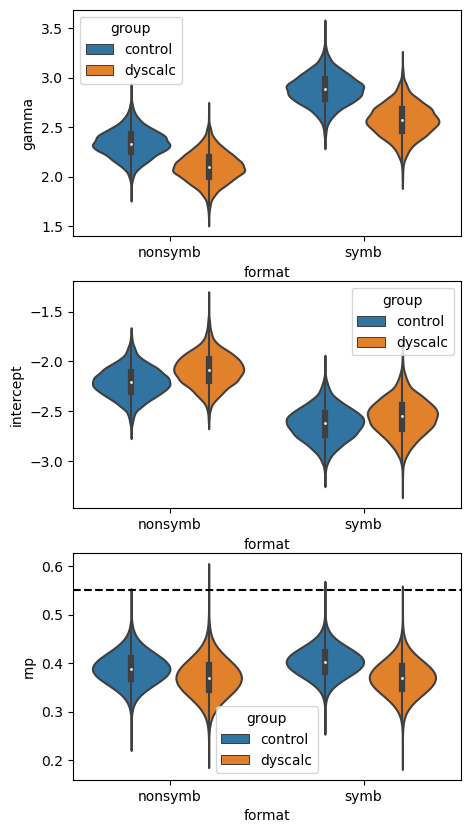

In [117]:
fig, axs = plt.subplots(3, 1, figsize=(5,10))
sns.violinplot(data=df_g, x='format', y='gamma', hue='group', ax=axs[0])
sns.violinplot(data=df_i, x='format', y='intercept', hue='group', ax=axs[1])
sns.violinplot(data=df_rnp, x='format', y='rnp', hue='group', ax=axs[2])
axs[2].axhline(y=0.55, color='black', linestyle='--')
plt.savefig(op.join(plot_folder, f'rnp_model-{model_label}_format-{format}_post-params.pdf'))

In [118]:
rnp_dif = np.asarray(df_comb[df_comb['group']=='control']['rnp'])  - np.asarray(df_comb[df_comb['group']=='dyscalc']['rnp'])
df_rnp_dif = pd.DataFrame(data=rnp_dif, index=df_comb[df_comb['group']=='control'].index).rename(mapper={0:'rnp_dif'},axis=1) #, columns='rnp_dif')
df_rnp_dif[['group', 'format']] = df_rnp_dif.reset_index()['group_format'].str.split('_', expand=True)

df_rnp_dif = df_rnp_dif.reset_index()
df_rnp_dif[['group', 'format']] = df_rnp_dif['group_format'].str.split('_', expand=True)
df_rnp_dif.head()


,group_format,rnp_dif,group,format
0,control_nonsymb,0.054005,control,nonsymb
1,control_nonsymb,0.045871,control,nonsymb
2,control_nonsymb,-0.013421,control,nonsymb
3,control_nonsymb,-0.026093,control,nonsymb
4,control_nonsymb,0.035001,control,nonsymb


Text(0.5, 1.3, 'RNP')

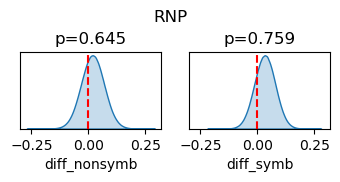

In [119]:
param = 'RNP'
fig, axs = plt.subplots(1,2, figsize=(4,1), sharex=True)
for i, var in enumerate(['nonsymb', 'symb']):
    temp = df_rnp_dif[df_rnp_dif['format'] == var]['rnp_dif']
    sns.kdeplot(temp, ax=axs[i],legend=False, fill=True)
    axs[i].axvline(x=0, color='r', linestyle='--')
    axs[i].set(yticks=[],ylabel='', xlabel=f'diff_{var}')
    axs[i].set_title(f'p={np.round(np.mean(temp > 0),3)}') # {var},\n 
fig.suptitle(param, y=1.3)

## PPCs

In [29]:
model_label = 1

df = get_data()
df['x'] = df['log(risky/safe)']

if model_label == 1:
    model = bambi.Model('chose_risky ~ x + x*group*format + (x*format|subject)', link='probit', family='bernoulli', data=df.reset_index())
    traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-both_trace.netcdf'))

if model_label == 2:
    format = 'symbolic'
    #df = df.xs(format, 0, level='format')
    model = bambi.Model('chose_risky ~ x + x*group*n_safe + (x*n_safe|subject)', link='probit', family='bernoulli', data=df.reset_index())
    traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [30]:
from utils_03 import format_bambi_ppc, summarize_ppc, plot_ppc

ppc = format_bambi_ppc(traces, model, df)
summarize_ppc(ppc, groupby=None)


/Users/mrenke/git/numrisk/numrisk/behavior_risk/utils_03.py:127: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


p_predicted  \
variable     subject session format       trial_nr choice n1   n2   prob1 prob2 risky_left chose_risky n_risky n_safe frac     log(risky/safe) log(n1)  bin(risky/safe) p1 p2   group x                       
ll_bernoulli 13      1       non-symbolic 1        True   7.0  16.0 0.55  1.00  True       True        16.0    7.0    2.285714 0.826679        2.772589 56%             1  0.55 1     0.826679     0.362000   
                                          2        False  5.0  7.0  0.55  1.00  True       False       7.0     5.0    1.400000 0.336472        1.945910 32%             1  0.55 1     0.336472     0.135000   
                                          3        True   7.0  14.0 0.55  1.00  True       True        14.0    7.0    2.000000 0.693147        2.639057 44%             1  0.55 1     0.693147     0.286750   
                                          4        False  7.0  9.0  0.55  1.00  True       False       9.0     7.0    1.285714 0.251314        2.197225 20%             1  0.55 1     0.251314     0.110750   
                                          6        True   7.0  14.0 0.55  1.00  True       True        14.0    7.0    2.000000 0.693147        2.639057 44%             1  0.55 1     0.693147     0.288750   
...                                                                                                                                                                                                     ...   
p            57      1       symbolic     188      False  28.0 47.0 1.00  0.55  False      False       47.0    28.0   1.678571 0.517943        3.332205 44%             1  0.55 0     0.517943     0.017318   
                                          189      False  5.0  8.0  1.00  0.55  False      False       8.0     5.0    1.600000 0.470004        1.609438 32%             1  0.55 0     0.470004     0.013133   
                                          190      False  20.0 28.0 1.00  0.55  False      False       28.0    20.0   1.400000 0.336472        2.995732 32%             1  0.55 0     0.336472     0.005830   
                                          191      False  7.0  14.0 1.00  0.55  False      False       14.0    7.0    2.000000 0.693147        1.945910 44%             1  0.55 0     0.693147     0.044185   
                                          192      False  20.0 33.0 1.00  0.55  False      False       33.0    20.0   1.650000 0.500775        2.995732 44%             1  0.55 0     0.500775     0.015700   

                                                                                                                                                                                                  hdi025  \
variable     subject session format       trial_nr choice n1   n2   prob1 prob2 risky_left chose_risky n_risky n_safe frac     log(risky/safe) log(n1)  bin(risky/safe) p1 p2   group x                    
ll_bernoulli 13      1       non-symbolic 1        True   7.0  16.0 0.55  1.00  True       True        16.0    7.0    2.285714 0.826679        2.772589 56%             1  0.55 1     0.826679  0.000000   
                                          2        False  5.0  7.0  0.55  1.00  True       False       7.0     5.0    1.400000 0.336472        1.945910 32%             1  0.55 1     0.336472  0.000000   
                                          3        True   7.0  14.0 0.55  1.00  True       True        14.0    7.0    2.000000 0.693147        2.639057 44%             1  0.55 1     0.693147  0.000000   
                                          4        False  7.0  9.0  0.55  1.00  True       False       9.0     7.0    1.285714 0.251314        2.197225 20%             1  0.55 1     0.251314  0.000000   
                                          6        True   7.0  14.0 0.55  1.00  True       True        14.0    7.0    2.000000 0.693147        2.639057 44%             1  0.55 1     0.693147  0.000000   
...                                                                     

In [ ]:
if model_label == 2:
    ppc['format'] = format
    ppc = ppc.set_index(['format'], append=True)
    
    df['format'] = format
    df = df.set_index('format', append=True)

In [31]:
level = 'group' # 'subject'
for plot_type in [1,2]:
    plot_ppc(df, ppc,level=level, plot_type=plot_type)
    plt.savefig(op.join(plot_folder, f'ppc_rnp_model-{model_label}_format-{format}_plot-{plot_type}_{level}.pdf'))
    plt.close()

/Users/mrenke/git/numrisk/numrisk/behavior_risk/utils_03.py:53: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject', 'group']+groupby).mean()
/Users/mrenke/git/numrisk/numrisk/behavior_risk/utils_03.py:127: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/mrenke/git/numrisk/numrisk/behavior_risk/utils_03.py:62: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p = df.groupby(groupby).mean()[['chose_risky']]


    group        format log(risky/safe)  p_predicted    hdi025    hdi975  \
0       0  non-symbolic             20%     0.064581  0.048704  0.079281   
1       0  non-symbolic             32%     0.144516  0.124436  0.166118   
2       0  non-symbolic             44%     0.275133  0.250225  0.301690   
3       0  non-symbolic             56%     0.438287  0.410841  0.467018   
4       0  non-symbolic             68%     0.610283  0.579850  0.641113   
5       0  non-symbolic             80%     0.755260  0.727224  0.783246   
6       0      symbolic             20%     0.039184  0.026903  0.051515   
7       0      symbolic             32%     0.116981  0.098071  0.137331   
8       0      symbolic             44%     0.270391  0.244318  0.294705   
9       0      symbolic             56%     0.468085  0.437436  0.495122   
10      0      symbolic             68%     0.661956  0.631025  0.689075   
11      0      symbolic             80%     0.808611  0.783704  0.833741   
12      1  n

/Users/mrenke/git/numrisk/numrisk/behavior_risk/utils_03.py:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject', 'group']+groupby).mean()
/Users/mrenke/git/numrisk/numrisk/behavior_risk/utils_03.py:127: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/mrenke/git/numrisk/numrisk/behavior_risk/utils_03.py:62: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p = df.groupby(groupby).mean()[['chose_risky']]


    group        format  n_safe  p_predicted    hdi025    hdi975  chose_risky
0       0  non-symbolic     5.0     0.367945  0.344286  0.391096     0.367210
1       0  non-symbolic     7.0     0.370604  0.346540  0.393571     0.369628
2       0  non-symbolic    10.0     0.377190  0.353189  0.400202     0.371429
3       0  non-symbolic    14.0     0.380718  0.358260  0.405456     0.372624
4       0  non-symbolic    20.0     0.383343  0.360029  0.407652     0.372978
5       0  non-symbolic    28.0     0.385441  0.362659  0.409580     0.410256
6       0      symbolic     5.0     0.379668  0.357496  0.401548     0.250000
7       0      symbolic     7.0     0.379512  0.358959  0.402766     0.315890
8       0      symbolic    10.0     0.387023  0.365078  0.409111     0.313987
9       0      symbolic    14.0     0.395973  0.374416  0.417467     0.424618
10      0      symbolic    20.0     0.395695  0.374047  0.418068     0.466223
11      0      symbolic    28.0     0.399900  0.378016  0.423915

### transform parameters into KLW model parameters (sd evi & prior)

In [ ]:
from utils import extract_rnp_precision

intercept, gamma = extract_rnp_precision(traces, model, df, format = True, group=True)
rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])

In [13]:
intercept_ar = np.asarray(intercept.stack([1,2]))
gamma_ar = np.asarray(gamma.stack([1,2]))


In [39]:
sd_ev = 1/(np.sqrt(2) * gamma_ar)
#sd_prior = np.sqrt( (- sd_ev/(np.sqrt(2) * np.log(0.55))) /  (intercept_ar + (1/ (np.sqrt(2) * sd_ev * np.log(0.55))) ) ) # tau
sd_prior = np.sqrt( (- sd_ev* np.log(1/.55)/(np.sqrt(2) )) /  (intercept_ar + (1 * np.log(1/.55)/ (np.sqrt(2) * sd_ev )) ) ) # tau
sd_prior

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_13970/3048223925.py:3: RuntimeWarning: invalid value encountered in sqrt
  sd_prior = np.sqrt( (- sd_ev* np.log(1/.55)/(np.sqrt(2) )) /  (intercept_ar + (1 * np.log(1/.55)/ (np.sqrt(2) * sd_ev )) ) ) # tau


array([[0.5070416 ],
       [0.50716992],
       [0.5687643 ],
       ...,
       [0.3374163 ],
       [0.34190468],
       [0.31394353]])

In [21]:
# sd_ev = 1/(np.sqrt(2) * gamma) # nu
# sd_prior = np.sqrt( (sd_ev/(np.sqrt(2) * np.log(0.55))) /  (intercept - (1/ (np.sqrt(2) * sd_ev * np.log(0.55))) ) ) # tau


/Users/mrenke/mambaforge/envs/behav_fit2_clone/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


In [44]:
len(sd_prior)

6144000

In [45]:
df_klw_params = pd.DataFrame(data={'sd_ev':sd_ev, 'sd_prior':sd_prior}, index=intercept.stack([1,2]).index)

In [48]:
df_klw_params#.groupby('subject').mean() 

sd_ev  sd_prior
subject n_safe format       group chain draw                    
13      7.0    non-symbolic 1     0     0     0.444703  0.507042
                                        1     0.421340  0.507170
                                        2     0.344625  0.568764
                                        3     0.364959  0.438283
                                        4     0.401227  0.521447
...                                                ...       ...
57      28.0   symbolic     0     3     995   0.234143  0.344186
                                        996   0.223843  0.299214
                                        997   0.227571  0.337416
                                        998   0.232936  0.341905
                                        999   0.232377  0.313944

[6144000 rows x 2 columns]

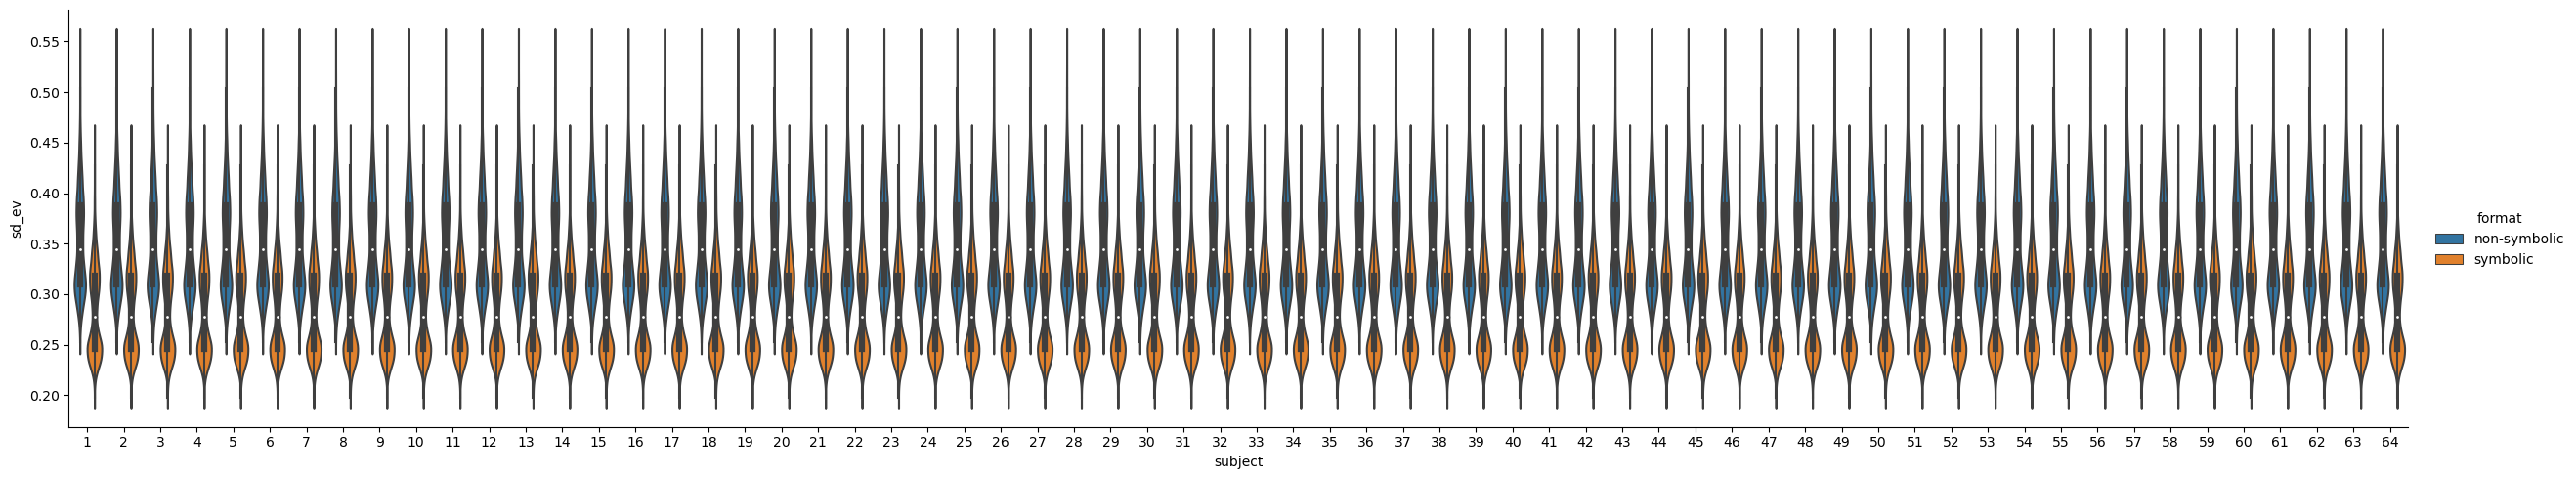

In [49]:
fac = sns.catplot(x='subject', y='sd_ev', data=df_klw_params.reset_index(), hue='format', aspect=5., kind='violin')
